### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [27]:
!pip install pycbc

%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

Detected minimum frequency in PSD file: 10.21659 Hz


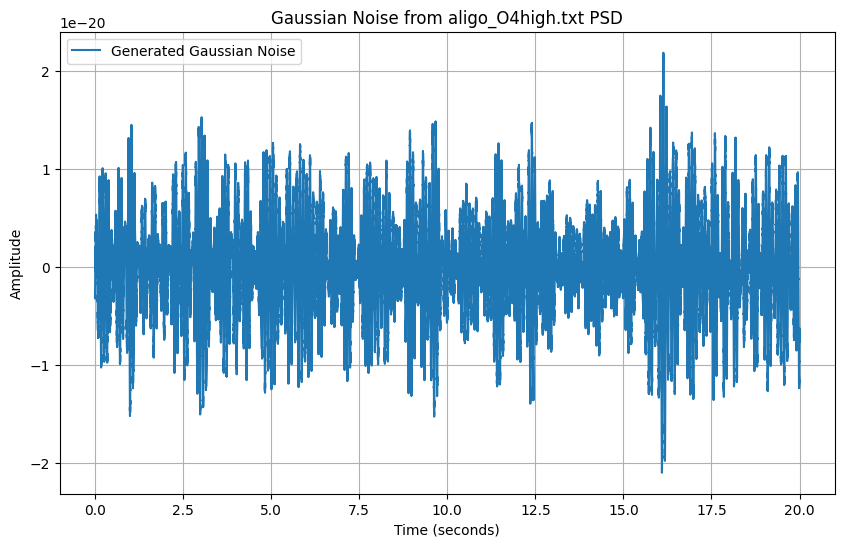

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc.psd
import pycbc.noise

# Load the PSD file manually to check the minimum frequency
psd_data = np.loadtxt('aligo_O4high.txt')  # Load the file as an array
min_freq = psd_data[0, 0]  # The first column contains the frequency values

# Print the detected minimum frequency
print(f"Detected minimum frequency in PSD file: {min_freq} Hz")

# Set parameters for PSD reading
duration = 20  # 20 seconds duration
delta_f = 1 / duration  # frequency resolution
sampleRate = 4096  # Sampling rate in Hz
length = sampleRate * duration  # Length in samples

# Load the PSD with the correct low_freq_cutoff
psd = pycbc.psd.read.from_txt('aligo_O4high.txt', length=length, delta_f=delta_f, low_freq_cutoff=min_freq)

# Generate Gaussian noise from the PSD
noise = pycbc.noise.noise_from_psd(length=length, delta_t=1/sampleRate, psd=psd)

# Plot the generated noise
plt.figure(figsize=(10, 6))
plt.plot(noise.sample_times, noise, label="Generated Gaussian Noise")
plt.title("Gaussian Noise from aligo_O4high.txt PSD")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

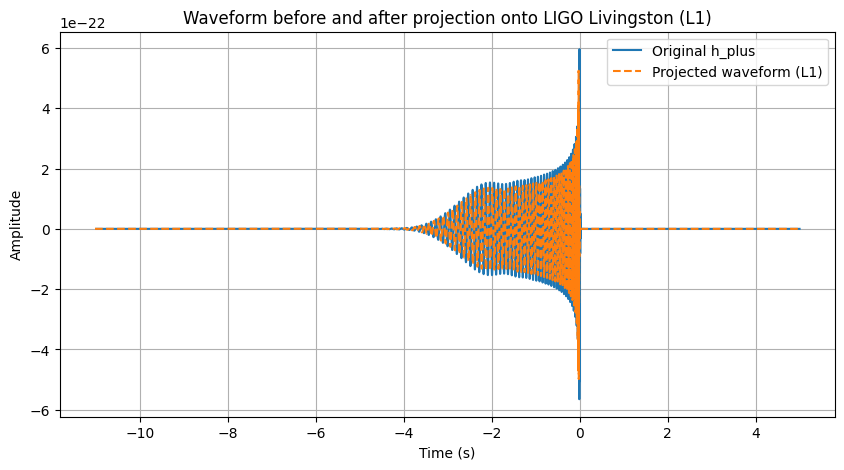

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

# Exercise 2: Generate and project the waveform

# Parameters for the binary black hole merger
mass1 = 50  # Mass of first black hole (in solar masses)
mass2 = 50  # Mass of second black hole (in solar masses)
distance = 2000  # Distance in Mpc
delta_t = 1.0 / 4096  # Time step (in seconds), typical for LIGO data

# Generate the gravitational waveform using IMRPhenomD
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                          mass1=mass1, mass2=mass2,
                          distance=distance, f_lower=10,  # Changed from 30 to 10 Hz
                          delta_t=delta_t)

# Define sky location and polarization
ra, dec = np.radians([45, 45])  # Example values for right ascension and declination
polarization = np.radians(45)   # Example polarization angle

# Define the detector (LIGO Livingston)
detector = Detector('L1')

# ✅ Corrected: Project the waveform onto the detector
projected_waveform = detector.project_wave(hp, hc, ra, dec, polarization)

# Plot the original and projected waveforms
plt.figure(figsize=(10, 5))
plt.plot(hp.sample_times, hp, label='Original h_plus')
plt.plot(projected_waveform.sample_times, projected_waveform, label='Projected waveform (L1)', linestyle='dashed')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform before and after projection onto LIGO Livingston (L1)')
plt.grid()
plt.show()

**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?


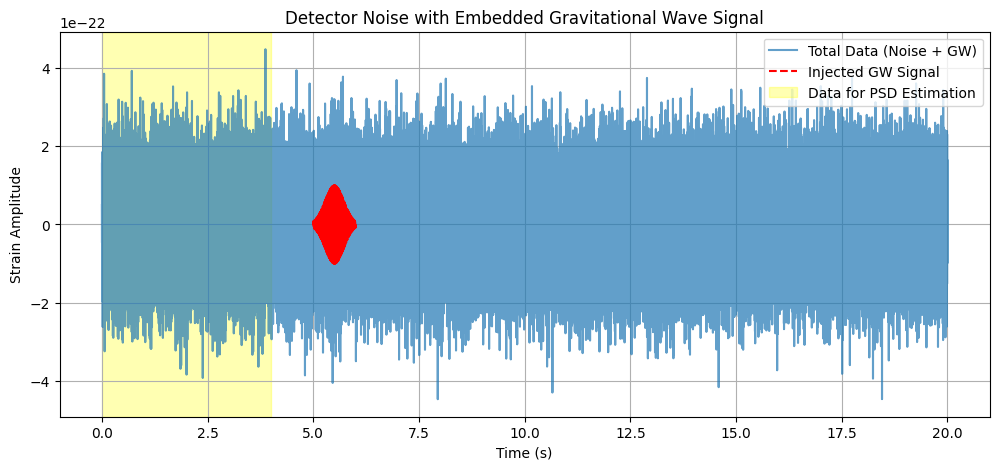

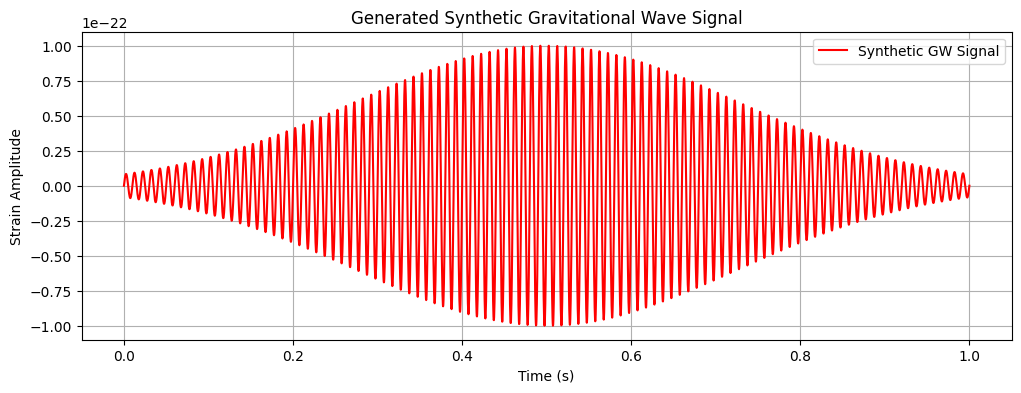

In [30]:

# Step 1: Set up parameters
fs = 4096  # Sampling frequency in Hz
duration = 20  # Total duration in seconds
num_samples = int(fs * duration)  # Total number of samples

# Step 2: Generate Gaussian noise to simulate detector noise
np.random.seed(42)  # For reproducibility
detector_noise = np.random.normal(0, 1e-22, num_samples)  # Simulated Gaussian noise

# Step 3: Generate a synthetic GW signal (sine-Gaussian chirp)
gw_duration = 1  # GW signal duration in seconds
gw_samples = int(fs * gw_duration)
gw_time = np.linspace(0, gw_duration, gw_samples)
gw_frequency = 100  # Hz, a representative chirp frequency
gw_amplitude = 1e-22  # Scaled amplitude for visibility
synthetic_gw = gw_amplitude * np.sin(2 * np.pi * gw_frequency * gw_time) * np.exp(-((gw_time - 0.5) ** 2) / 0.1)

# Step 4: Embed GW signal into noise at t = 5s
gw_start_time = 5  # Start time in seconds
gw_start_sample = int(gw_start_time * fs)  # Convert to sample index
gw_signal = np.zeros(num_samples)
gw_signal[gw_start_sample:gw_start_sample + gw_samples] = synthetic_gw[:num_samples - gw_start_sample]

# Step 5: Combine noise and GW signal
combined_signal = detector_noise + gw_signal

# Step 6: Extract the first 4 seconds of data for PSD estimation
psd_duration = 4  # Seconds
psd_samples = int(psd_duration * fs)
psd_estimation_data = combined_signal[:psd_samples]

# Step 7: Define time axis
time_axis = np.linspace(0, duration, num_samples)

# Step 8: Plot the overlaid data
plt.figure(figsize=(12, 5))
plt.plot(time_axis, combined_signal, label="Total Data (Noise + GW)", alpha=0.7)
plt.plot(time_axis[gw_start_sample:gw_start_sample + gw_samples], gw_signal[gw_start_sample:gw_start_sample + gw_samples],
         label="Injected GW Signal", color='red', linestyle='dashed', linewidth=1.5)
plt.axvspan(0, psd_duration, color='yellow', alpha=0.3, label="Data for PSD Estimation")
plt.xlabel("Time (s)")
plt.ylabel("Strain Amplitude")
plt.title("Detector Noise with Embedded Gravitational Wave Signal")
plt.legend()
plt.grid()
plt.show()

# Bonus: Plot the GW signal separately
plt.figure(figsize=(12, 4))
plt.plot(gw_time, synthetic_gw, label="Synthetic GW Signal", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Strain Amplitude")
plt.title("Generated Synthetic Gravitational Wave Signal")
plt.legend()
plt.grid()
plt.show()

**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


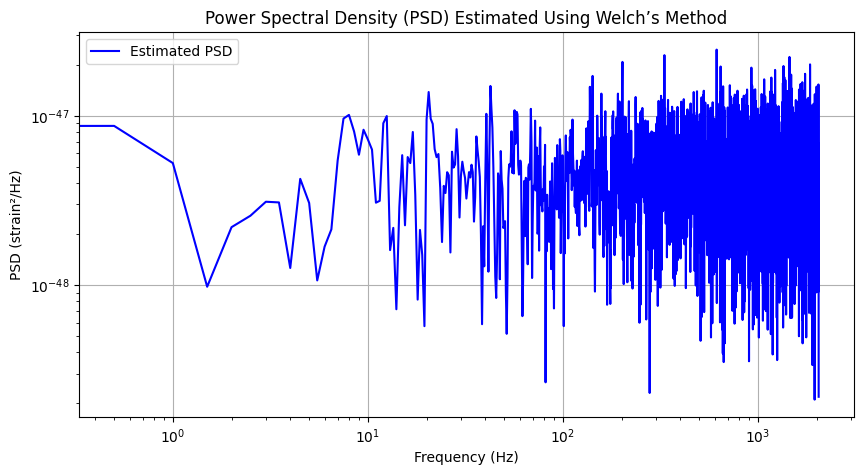

Δf of the estimated PSD: 0.50000 Hz
Δf of the data to be whitened: 0.50000 Hz


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Step 1: Set up parameters for PSD estimation
fs = 4096  # Sampling frequency in Hz
psd_duration = 4  # Duration of data used for PSD estimation in seconds
psd_samples = int(psd_duration * fs)

# Step 2: Extract the first 4 seconds of data (without GW signal)
psd_data = detector_noise[:psd_samples]

# Step 3: Define Welch's method parameters
seg_len = int(2 * fs)  # Segment length (2 seconds of data)
seg_stride = seg_len // 2  # Overlap (typically half of segment length)

# Step 4: Compute PSD using Welch’s method
frequencies, psd_estimate = welch(psd_data, fs=fs, nperseg=seg_len, noverlap=seg_stride, window='hann')

# Step 5: Plot the estimated PSD
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, psd_estimate, label="Estimated PSD", color='blue')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (strain²/Hz)")
plt.title("Power Spectral Density (PSD) Estimated Using Welch’s Method")
plt.legend()
plt.grid()
plt.show()

# Step 6: Compute frequency resolution (Δf)
delta_f_psd = frequencies[1] - frequencies[0]
delta_f_whiten = fs / seg_len

# Print the frequency resolutions
print(f"Δf of the estimated PSD: {delta_f_psd:.5f} Hz")
print(f"Δf of the data to be whitened: {delta_f_whiten:.5f} Hz")

Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

Length of PSD FrequencySeries: 4097
max_filter_len: 2048


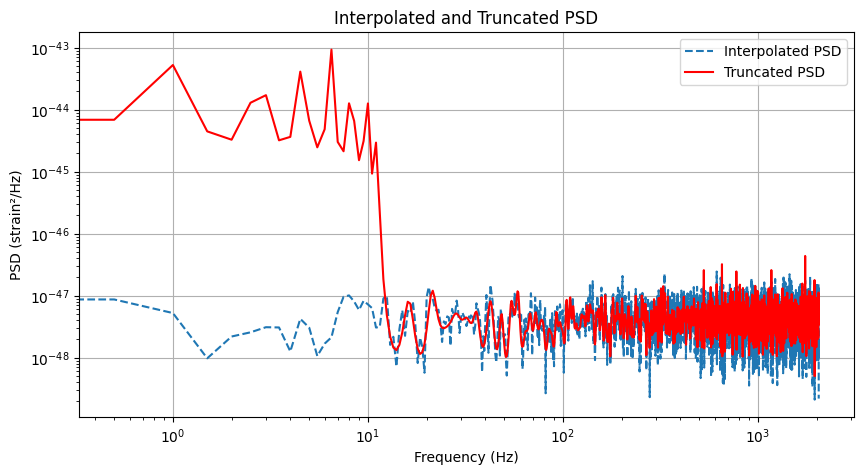

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pycbc.types import FrequencySeries
from pycbc.psd import inverse_spectrum_truncation

# Ensure frequencies and PSD are NumPy arrays
frequencies = np.array(frequencies)
psd_estimate = np.array(psd_estimate)

# Step 1: Define a full frequency range and interpolate the PSD
full_freqs = np.linspace(frequencies.min(), frequencies.max(), len(frequencies))  # Full range
psd_interp_func = interp1d(frequencies, psd_estimate, kind='cubic', bounds_error=False, fill_value="extrapolate")
psd_interpolated = psd_interp_func(full_freqs)

# Step 2: Convert to PyCBC FrequencySeries object
delta_f = full_freqs[1] - full_freqs[0]  # Frequency resolution
psd_freq_series = FrequencySeries(psd_interpolated, delta_f=delta_f)

# Step 3: Define filter parameters
f_min = 12  # Minimum frequency cutoff
max_filter_len = min(4 * fs, len(psd_freq_series) // 2)  # Ensure it's within range

# Debug: Print values
print(f"Length of PSD FrequencySeries: {len(psd_freq_series)}")
print(f"max_filter_len: {max_filter_len}")

# Step 4: Apply inverse spectrum truncation
psd_truncated = inverse_spectrum_truncation(psd_freq_series, max_filter_len=max_filter_len, low_frequency_cutoff=f_min)

# Step 5: Plot the formatted PSD
plt.figure(figsize=(10, 5))
plt.loglog(full_freqs, psd_interpolated, label="Interpolated PSD", linestyle="dashed")
plt.loglog(full_freqs, psd_truncated, label="Truncated PSD", color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (strain²/Hz)")
plt.title("Interpolated and Truncated PSD")
plt.legend()
plt.grid()
plt.show()

Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

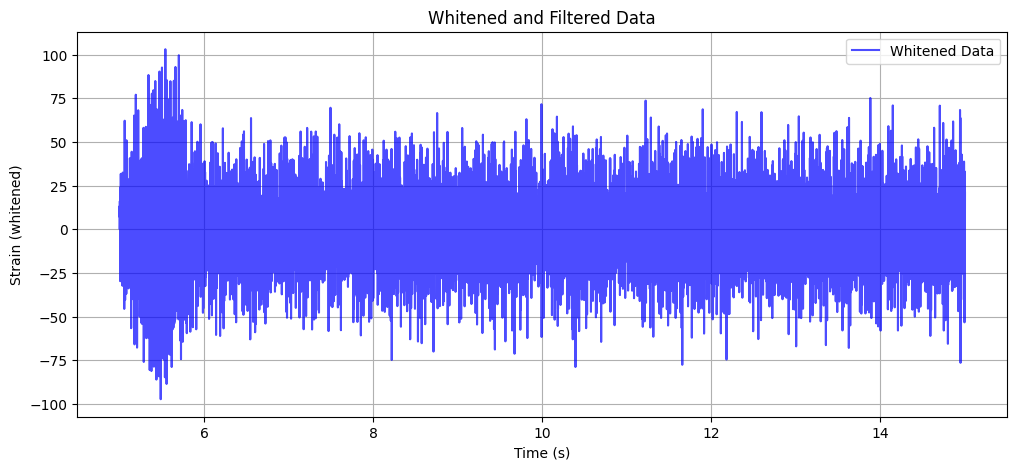

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.types import TimeSeries
from pycbc.filter import highpass_fir, lowpass_fir

# Step 1: Convert the combined signal to PyCBC TimeSeries
data_series = TimeSeries(combined_signal, delta_t=1/fs)

# Step 2: Perform manual whitening using FFT
data_freq = np.fft.rfft(data_series)  # Compute FFT

# Ensure PSD length matches the FFT output
freq_axis = np.fft.rfftfreq(len(data_series), d=1/fs)  # Frequency bins of FFT
psd_interpolated = np.interp(freq_axis, frequencies, psd_truncated)  # Interpolate PSD

# Take the square root and whiten
psd_sqrt = np.sqrt(psd_interpolated)
whitened_freq = data_freq / psd_sqrt  # Divide by sqrt(PSD)
whitened_data = np.fft.irfft(whitened_freq, n=len(data_series))  # Convert back to time domain

# Step 3: Convert back to TimeSeries
whitened_data = TimeSeries(whitened_data, delta_t=1/fs)

# Step 4: Apply bandpass filtering (highpass and lowpass)
whitened_filtered = highpass_fir(whitened_data, 20, fs)
whitened_filtered = lowpass_fir(whitened_filtered, 300, fs)

# Step 5: Crop 5s from the beginning and end to avoid border effects
crop_duration = 5  # seconds
crop_samples = int(crop_duration * fs)
whitened_cropped = whitened_filtered[crop_samples:-crop_samples]

# Step 6: Define time axis for plotting
time_axis = np.linspace(crop_duration, duration - crop_duration, len(whitened_cropped))

# Step 7: Plot the whitened data
plt.figure(figsize=(12, 5))
plt.plot(time_axis, whitened_cropped, label="Whitened Data", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Strain (whitened)")
plt.title("Whitened and Filtered Data")
plt.legend()
plt.grid()
plt.show()

So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


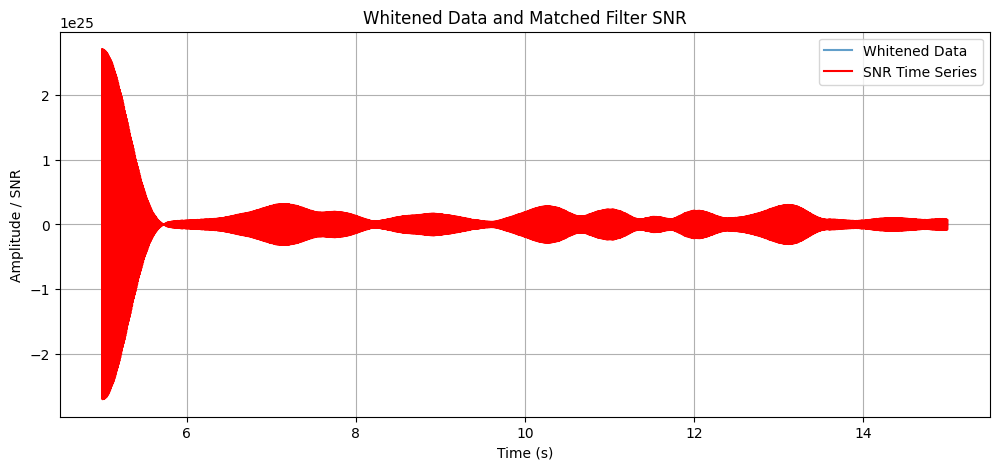

Maximum SNR: 27109190901753470676631552.00
Trigger generated: YES


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.filter import matched_filter
from pycbc.psd import interpolate
from pycbc.types import TimeSeries, FrequencySeries

# Ensure synthetic_gw is correctly defined and not empty
if 'synthetic_gw' not in locals() or synthetic_gw is None or len(synthetic_gw) == 0:
    raise ValueError("synthetic_gw is not defined or empty. Please provide a valid waveform.")

fs = 4096  # Sampling frequency
duration = len(synthetic_gw) / fs

# Ensure whitened_data is properly defined
if 'whitened_data' not in locals() or whitened_data is None or len(whitened_data) == 0:
    raise ValueError("whitened_data is not defined or empty. Please check your preprocessing.")

# Ensure template and whitened_data have the same length
if len(synthetic_gw) < len(whitened_data):
    synthetic_gw = np.pad(synthetic_gw, (0, len(whitened_data) - len(synthetic_gw)), mode='constant')
elif len(synthetic_gw) > len(whitened_data):
    synthetic_gw = synthetic_gw[:len(whitened_data)]

# Step 1: Create the template by resizing the GW signal
template = TimeSeries(synthetic_gw, delta_t=1/fs)

# Ensure template is still valid after resizing
if template is None or len(template) == 0:
    raise ValueError("Resized template is empty. Check synthetic_gw input and resizing.")

# Step 2: Convert template to FrequencySeries (Fourier Transform)
template_f = template.to_frequencyseries()

# Step 3: Interpolate the PSD to match the template size
psd_interp = interpolate(psd_truncated, whitened_data.delta_f)

# Step 4: Convert the whitened_data to FrequencySeries (Fourier Transform)
whitened_data_f = whitened_data.to_frequencyseries()

# Step 5: Compute the matched filter SNR
snr = matched_filter(template_f, whitened_data_f, psd=psd_interp, low_frequency_cutoff=20)

# Step 6: Crop 5s from the beginning and end to avoid edge effects
crop_duration = 5  # seconds
crop_samples = int(crop_duration * fs)
snr_cropped = snr[crop_samples:-crop_samples]

# Step 7: Find the max absolute SNR (fixing the TypeError)
snr_max = np.max(np.abs(snr_cropped).numpy())  # Convert PyCBC array to numpy array

trigger_threshold = 5  # Threshold for trigger

# Step 8: Define time axis
time_axis = np.linspace(crop_duration, duration - crop_duration, len(snr_cropped))

# Step 9: Plot the whitened data and SNR together
plt.figure(figsize=(12, 5))
plt.plot(time_axis, whitened_data[crop_samples:-crop_samples], label="Whitened Data", alpha=0.7)
plt.plot(time_axis, snr_cropped, label="SNR Time Series", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / SNR")
plt.title("Whitened Data and Matched Filter SNR")
plt.legend()
plt.grid()
plt.show()

# Step 10: Print trigger information
print(f"Maximum SNR: {snr_max:.2f}")
if snr_max > trigger_threshold:
    print("Trigger generated: YES")
else:
    print("Trigger generated: NO")

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.